# 1. Overview

This notebook outlines a process for predicting future ASML stock prices using Prophet models. It includes training the model with historical data, adding exogenous variables (such as geopolitical events and supplier performance), and generating predictions for upcoming weeks. Supplier-specific Prophet models were utilized to forecast their stocks, which were then integrated into the ASML model to account for external factors. The final predictions show ASML's stock price trends, providing insights into the impact of supplier and geopolitical data on future performance.

# 2. Future Predictions

## 2.1 Import Libraries

In [1]:
import pandas as pd
import json
import joblib
from sktime.utils.plotting import plot_series
from prophet import Prophet

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global Variables

In [2]:
input_best_params_path  = 'data/best_prophet_params.json'
input_regressors_path = 'data/best_regressors.json'
input_data = 'data/weekly_data_combination.csv'
future_weeks = 2

## 2.3 Functions

In [3]:
# Function to add exogenous variables to the future_dataframe
def add_exogenous_variables(future_df: pd.DataFrame, list_exogenous: list):
    """
    Input: 
        future_df (DataFrame) - A DataFrame containing future dates in the 'ds' column.
        list_exogenous (list) - List of exogenous variables to add.
    Output: 
        future_df (DataFrame) - The same DataFrame with added binary columns for specified exogenous events.
    Logic: 
        Adds binary indicators for each specified exogenous event based on predefined date ranges.
    """
    # Define the date ranges for each exogenous event
    exogenous_events = {
        'COVID_Period': ('2020-01-01', '2022-12-31'),
        'Geopolitical_Tension': ('2022-02-01', '2025-12-31'),
        'Trade_Sanctions': ('2018-07-01', '2029-12-31'),
        'Tech_Regulation': ('2020-06-01', '2029-12-31'),
        'New_Product_Launch': ('2023-12-01', '2025-12-31'),
        'Israel_Gaza_Conflict': ('2023-10-07', '2025-12-31'),
    }

    # Add binary columns for each exogenous variable in the list
    for exogenous in list_exogenous:
        if exogenous in exogenous_events:
            start_date, end_date = exogenous_events[exogenous]
            future_df[exogenous] = ((future_df['ds'] >= start_date) & 
                                    (future_df['ds'] <= end_date)).astype(int)
    
    return future_df

## 2.4 Code

### 2.4.1 Loading the data from notebook 04_data_preparation

In [4]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')

# Replace spaces with underscores in column names
weekly_data_combination.columns = [col.replace(" ", "_") for col in weekly_data_combination.columns]

weekly_data_combination

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.665680,60.946629,10.253906,32.766666,0,0,0,0,0,0
2018-01-21,185.740173,60.851776,10.981783,34.386667,0,0,0,0,0,0
2018-01-28,191.568512,61.373493,11.191770,34.026669,0,0,0,0,0,0
2018-02-04,187.829071,61.335560,10.222878,31.420000,0,0,0,0,0,0
2018-02-11,174.083649,58.831287,9.113811,28.526667,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2024-10-27,710.051941,67.529999,73.000000,76.709999,0,1,1,1,1,1
2024-11-03,683.830017,65.550003,75.449997,77.500000,0,1,1,1,1,1
2024-11-10,671.159973,62.200001,76.779999,76.449997,0,1,1,1,1,1


### 2.4.2 Loading the best regressors from notebook 05_modelling

In [5]:
# Load the best regressors from the JSON file
with open(input_regressors_path, 'r') as file:
    regressors = json.load(file)

regressors = regressors['chosen_regressors']   

### 2.4.3 Loading the best parameters from notebook 05_modelling

In [6]:
# Load the best parameters from the JSON file
with open(input_best_params_path, 'r') as file:
    best_params = json.load(file)     

### 2.4.4 Loading Suppliers Pickles

In [7]:
# Create an empty dictionary to store the loaded models
models_suppliers = {}

# Iterate over each supplier in regressors to load its model
for company in regressors:
    if 'Close' in company:
        company = company.replace('Close_', '')
        # Define the file path to the model pickle file for the current supplier
        model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'
        
        # Load the model and store it in the dictionary using the supplier's name
        models_suppliers[company] = joblib.load(model_path)
        print(f'Prophet model for {company} loaded from {model_path}')

Prophet model for Lam_Research_Corporation loaded from models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Carl_Zeiss_Meditec loaded from models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl


### 2.4.5 Train the model with new data

The prophet model that was trained in notebook 05_modelling, we are going to train it again with all the data without separating between train and test. 

In [8]:
# Initialize the Prophet model with the loaded best parameters
prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    daily_seasonality=best_params['daily_seasonality'],
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    weekly_seasonality=best_params['weekly_seasonality'],
    yearly_seasonality=best_params['yearly_seasonality']
)

Modify the column names as required by prophet

In [9]:
train_data = weekly_data_combination.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

Add regressors

In [10]:
for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [11]:
prophet_model.fit(train_data)

18:49:30 - cmdstanpy - INFO - Chain [1] start processing
18:49:30 - cmdstanpy - INFO - Chain [1] done processing


### 2.4.6 Building the future dataframe 

In [12]:
future_dataframe = prophet_model.make_future_dataframe(periods=future_weeks, freq='w')[-future_weeks:]
future_dataframe

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  dates = pd.date_range(


,ds
359,2024-12-01
360,2024-12-08


Predict the stock of ASML's suppliers using the prophet models of the suppliers that were done in notebook 03_selecting_asml_suppliers

In [13]:
# Iterate over each supplier in regressors to make predictions
for company in regressors:
    if 'Close' in company:
        company = company.replace('Close_', '')
        
        # Get the loaded Prophet model for the current supplier from the models_suppliers dictionary
        model = models_suppliers[company]

        # Generate predictions on the future_dataframe using the model
        forecast = model.predict(future_dataframe)

        # Select only 'ds' and 'yhat' columns, rename 'yhat' to 'Close_{company}'
        forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': f'Close_{company.replace(" ", "_")}'})

        # Merge the forecast data with the future_dataframe on the 'ds' column
        future_dataframe = future_dataframe.merge(forecast, on='ds', how='left')

In [14]:
future_dataframe

,ds,Close_Lam_Research_Corporation,Close_Carl_Zeiss_Meditec
0,2024-12-01,72.738553,66.376377
1,2024-12-08,72.920613,67.024381


Let's predict the exogenous variables into the future and add them to the future_dataframe as well 

In [15]:
# Apply the function to future_dataframe
add_exogenous_variables(future_dataframe, regressors)

future_dataframe

,ds,Close_Lam_Research_Corporation,Close_Carl_Zeiss_Meditec,Trade_Sanctions,New_Product_Launch,Israel_Gaza_Conflict
0,2024-12-01,72.738553,66.376377,1,1,1
1,2024-12-08,72.920613,67.024381,1,1,1


### 2.4.7 Predicting the stock values of ASML 

In [16]:
# Generate predictions
future_dataframe_ASML_stock = prophet_model.predict(future_dataframe)

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
future_dataframe_ASML_stock = future_dataframe_ASML_stock[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})

future_dataframe_ASML_stock

,Close
ds,
2024-12-01,727.087071
2024-12-08,728.099582


Let's do a representation of the results

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Close_ASML'>)

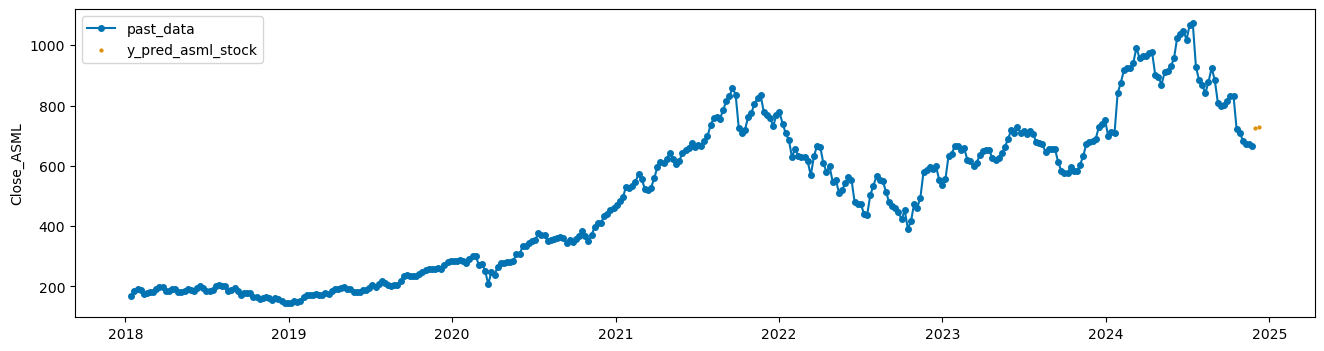

In [17]:
# Plot the series with train, test, and predictions from both models
plot_series(
    weekly_data_combination['Close_ASML'],             # Training data starting from index 500 for better visualization
    future_dataframe_ASML_stock,                       # Predictions from the ASML model
    labels=["past_data", "y_pred_asml_stock"]          # Labels for each line in the plot
)